In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("probability_sampling.ipynb")

# What is in this file/notebook

Slides: https://docs.google.com/presentation/d/1vZC32UCamhyJWJBQIuP5AXKK896mBges_eO2H3Vo3q4/edit?usp=sharing

How do you use numpy's stats package to simulate a random variable for:
a) Booleans (T/F)
b) Discrete variables (a, b, c)
c) Histogram versions of continuous variables (eg, location)

Think of these as functions as simulating real-world events - query the sensor for if the door is open (y/n), ask where the robot is (contiuous location OR a grid square in the world), ask which room you're in (discrete variable, kitchen dining room), take a distance reading with noise, etc. 

These can be thought of as fancy versions of a coin toss (returns T/F with 50% probability each), a roll of the dice (returns 1..6 with equal probability).

ALL of these "simulate probability" routines for discrete variables can be implemented using JUST numpy's uniform number generator  (generates a number between 0 and 1 with all values equally likely). The simplest way to think of all of these methods is that you chop up the unit interval 0..1 into the number of possible outcomes, with each bit of the unit interval representing how likely that event is. Then you just generate a number from 0 to 1 and see which bin you fell into.

Why the functions are set up they way they are: You need to input how likely each discrete event is. There's three basic methods for specifying this.
1) List each discrete event and how likely it is
2) All events are equally likely, just say how many there are (bins) and the mapping between the bins and the 'labels'.Usually the bins represent some spatial variable like location or angle, but could be a movement
3) There is a function that represents how likely each event is, with the x coordinate representing some continuous variable like distance (think Gaussian error for movement)

For each method that you'll implement the above information is passed in using a dictionary. I'm using a dictionary (instead of a class) because it's a bit easier to understand/implement, but the 'right' way to do this is as a class.

In [2]:
# The imports you'll need
import numpy as np
import matplotlib.pyplot as plt


## Boolean
Simplest random variable - returns True or False, with some probability

Since probability of returning False is 1-prob(True), only need to specify one value.


In [3]:
def sample_boolean_variable(info_variable : dict):
    """ Generate one sample from a boolean variable
    @param info_variable is a dictionary containing the probability of the variable returning True
    @returns True or False """

    # Probabilities have to be between 0 and 1...
    #. info_variable["prob_return_true"] accesses the value stored in the dictionary
    if info_variable["prob_return_true"] < 0.0 or info_variable["prob_return_true"] > 1.0:
        ValueError(f"Value {info_variable['prob_return_true']} not between zero and one")

    # First, use random.uniform to generate a number between 0 and one. Note that this is a uniform distribution, not
    #  a Gaussian one
    #   random is a library in numpy (np), and uniform is a function in the random library
    #   Google "numpy random"
    zero_to_one = np.random.uniform()

    # See slides - if the random variable is below the probability of returning true, return true. Otherwise, return false
    # GUIDE: Return True or False
    return zero_to_one < info_variable["prob_return_true"]

In [4]:
# First, check that you have no obvious syntax errors. This doesn't guarantee that your code is correct, just
#  that it doesn't crash and it returns True or False 
boolean_variable = {"prob_return_true": 0.3}
ret_val = sample_boolean_variable(boolean_variable)
if ret_val is True or ret_val is False:
    print("sample_boolean: Passed syntax check")


sample_boolean: Passed syntax check


In [5]:
# Test function: If your sample_boolean_variable is implemented correctly, then it should
#   return "True" approximately test_prob_value percent of the time. This function directly
#   checks that by, well, calling your function 1000 times and counting how many times it returned True...
def test_boolean(test_prob_value=0.6, n_samples=1000, b_print=True):
    """ Check if the sample_boolean is doing the right thing by calling it lots of times
    @param test_prob_value - any value between 0.0 and 1.0
    @param n_samples - how many samples to try. As this gets bigger, the percentage should get closer to test_prob_value
    @param b_print - whether or not to print out intermediate results
    @returns True if sample_boolean_variable is working correctly"""

    if b_print:
        print(f"Testing boolean with {test_prob_value} probability")
    boolean_info_variable = {"prob_return_true": test_prob_value}

    # Count number of True and number of False 
    count_true = 0
    count_false = 0
    for _ in range(0, n_samples):
        if sample_boolean_variable(boolean_info_variable) == True:
            count_true += 1
        else:
            count_false += 1

    # Turn counts into percentages
    perc_true = count_true / (count_true + count_false)
    if b_print:
        print(f"Perc true from sampling: {perc_true}, expected {boolean_info_variable['prob_return_true']}")

    # Always use np.isclose to compare floating point values
    #.  perc_true should hover around test_prob_value but it won't be exact
    if not np.isclose(perc_true, boolean_info_variable["prob_return_true"], atol=0.05):
        if b_print:
            print("Failed")
        return False

    if b_print:
        print("Passed")
    return True

In [6]:
# Note: This should return true and print out passed. However, sometimes the random number generator will not be
#  your friend and it will fail - you're expecting the count to come out around 0.6 +- noise

# This makes sure you are at least starting with the same seed for the pseudo random number generator
np.random.seed = 5
print(f"Boolean result: {test_boolean(test_prob_value=0.6)}")

Testing boolean with 0.6 probability
Perc true from sampling: 0.577, expected 0.6
Passed
Boolean result: True


In [7]:
grader.check("boolean_sample")

boolean_sample results: All test cases passed!

# Discrete random variable

A discrete random variable has a finite number of values it can take on (the keys in the dictionary)

Because we need one value for each variable, and a name for each variable, store this as name/probabilty key-value pair in a dictionary. Name is the key, probability is the value

If you have forgotten how to do dictionaries, go do the tutorial on dictionaries before attempting this problem

Hint: You want the .items() iterator. If you don't know what that is, or don't know what a key, value pair is, go do the tutorial.

In [8]:
def sample_discrete_variable(info_variable : dict):
    """ Generate one sample from the given discrete random variable
    Your code should NOT need to know what the actual keys are, how many there are, or what
    the actual values are - i.e., your code should NOT include things like
             if key == "True" or if z < 0.8
    @param info_variable contains pairs of values with probabilities. Probabilites should sum to one
    @returns one of the discrete values (keys) in the dictionary """

    # First, I'll do some checks for you
    for v in info_variable.values():
        # Probabilities have to be between 0 and 1...
        if v < 0.0 or v > 1.0:
            ValueError(f"Value {v} not between zero and one")

    # And they have to sum to one
    if not np.isclose(sum(info_variable.values()), 1.0):
        ValueError(f"Sum of probabilities should be 1, is {sum(info_variable.values())}")

    # Now, use random to generate a number between 0 and one
    zero_to_one = np.random.uniform()

    # See slides - "stack" the probabilities - if the value lies in the discrete value's stack, return that one
    # You should use a FOR loop. If you're struggling with the FOR loop, try writing this with an if - else if -else if
    #  for JUST the test case in the next cell - it won't work for test_discrete
    #  
    # GUIDE - return one of the key values in the dictionary. 
    # print(info_variable.items())
    total = 0
    for key, value in info_variable.items():
        # print(f"Key: {key}, value: {value}")
        # print(f"zero_to_one: {zero_to_one}")
        total += value
        if zero_to_one < total:
            return key


In [9]:
# Syntax check - does your code run and return a key?
#.  Does NOT check if your code is correct, just that it returns one of the keys

check_discrete_tri = {"red": 0.3, "green": 0.1, "blue": 0.6}

#. Call 10 times
b_passed = True
for _ in range(0, 10):
    ret_value = sample_discrete_variable(check_discrete_tri)
    if not (ret_value == "red" or ret_value == "green" or ret_value == "blue"):
        b_passed = False
        print(f"Discrete: Failed syntax check, returned {ret_value}, expected red, green, or blue string")

if b_passed:
    print("Passed syntax check")

Passed syntax check


In [10]:
def test_discrete(n_samples=10000, b_print=True):
    """ Test three different random variables
    @param n_samples - number of times to sample, bigger numbers are slower but more accurate
    @param b_print - set to True if you want a lot of stuff printed out
    @return True (passed) or False (did not pass)"""
    if b_print:
        print("Testing discrete")

    # The following for loop will loop through each of these in turn. It is NOT doing them all at the
    #  same time - the first time through the for loop it will check the boolean case, the second time
    #  the red, green, blue, the third time the quad one
    check_boolean = {"True": 0.2, "False": 0.8}
    check_discrete_tri = {"red": 0.1, "green": 0.6, "blue": 0.3}
    check_discrete_quad = {"kitchen": 0.2, "living room": 0.3, "dining room": 0.4, "bed room": 0.1}

    # check_variable will be check_boolean, then check_disrete_tri, then check_discrete_quad
    for check_variable in [check_boolean, check_discrete_tri, check_discrete_quad]:
        if b_print:
            print(f"Checking dictionary: {check_variable}")
        # For each discrete variable, set the counts to be zero; save as dictionary (rather than array/list) because
        #   the keys are strings
        counts = {}   # Empty dictionary
        for k in check_variable.keys():
            counts[k] = 0  # Add a key, 0 pair for each key

        # 'throw the dice' (sample) multiple times, and update counts as you go
        for _ in range(0, n_samples):
            # Get a sample from the distribution - should return one of the keys
            ret_key = sample_discrete_variable(check_variable)
            # Add one to that discrete variable's count
            counts[ret_key] += 1

        # Now compare the percentage values
        for k, v in check_variable.items():
            # How many times did I get this key?
            perc = counts[k] / n_samples
            if b_print:
                print(f"Discrete value: {k}, got: {perc}, expected {v}")

            if not np.isclose(perc, v, atol=0.05):
                if b_print:
                    print("Failed")
                return False
        if b_print:
            print(" Passed\n")
    return True

In [11]:
# Note, this is a little slow
# If you want to speed it up, decrease number of samples
np.random.seed = 10
res = test_discrete(n_samples=3000, b_print=True)
if res:
    print(f"Passed discrete test")
else:
    print(f"Failed discrete test")

Testing discrete
Checking dictionary: {'True': 0.2, 'False': 0.8}
Discrete value: True, got: 0.20166666666666666, expected 0.2
Discrete value: False, got: 0.7983333333333333, expected 0.8
 Passed

Checking dictionary: {'red': 0.1, 'green': 0.6, 'blue': 0.3}
Discrete value: red, got: 0.094, expected 0.1
Discrete value: green, got: 0.6013333333333334, expected 0.6
Discrete value: blue, got: 0.30466666666666664, expected 0.3
 Passed

Checking dictionary: {'kitchen': 0.2, 'living room': 0.3, 'dining room': 0.4, 'bed room': 0.1}
Discrete value: kitchen, got: 0.20233333333333334, expected 0.2
Discrete value: living room, got: 0.29833333333333334, expected 0.3
Discrete value: dining room, got: 0.4106666666666667, expected 0.4
Discrete value: bed room, got: 0.08866666666666667, expected 0.1
 Passed

Passed discrete test


In [12]:
grader.check("discrete")

discrete results: All test cases passed!

# Binning (histograms)

It is common to represent continuous variables as a set of discrete values (eg, on a scale of 1 to 10, how much do you like this problem?). This is common with locations (grid up the space), images (pixels), volume levels on most digital devices, etc. This is often called *binning*, because you are binning continuous values into discrete bins.

You can also think of binning as a type of histogram.

Creating a discrete random variable for a binned continuous variable is actually a special case of the discrete random variable - it's just that we don't need to explicitly label each discrete value. Instead the "labels" are the (typically) the value at the center of the bin. Rather than specifying unique labels for each bin, it's normal to just provide the start/stop boundaries and the number of divisions. The usual assumption is that all bins are equally likely; so if there are n bins, then the probability of generating any specific bin label is 1/n.

Your solution should NOT have a loop in it - you should be able to calculate which bin **zero_to_one** lies in directly (see np.floor(x)).

I've included a couple of "helper" functions to convert from a zero to one range to a start-stop range and back again.

In [13]:
# Note: this function should work even if value is NOT between start and stop
#  If value is start, should return 0
#  If value is stop, should return 1
#. If value is halfway between start and stop, should return 0.5
#.   and so on

# given a number and endpoints of a distribution, at what percentile does that number fall?
def convert_start_stop_to_zero_one(value : float, start : float, stop : float):
    """ This takes in a number between start and stop and returns a number between 0 and 1 
    @param value : the value to convert
    @param start : left side of the interval
    @param stop : right side of the interval
    @preturn how far value is from start to stop"""

    # GUIDE return the percentage along
    return (value - start) / (stop - start)

In [14]:
# Checking your conversion
assert np.isclose(convert_start_stop_to_zero_one(3.0, 3.0, 6.0), 0.0)
assert np.isclose(convert_start_stop_to_zero_one(6.0, 3.0, 6.0), 1.0)
assert np.isclose(convert_start_stop_to_zero_one(4.5, 3.0, 6.0), 0.5)
assert np.isclose(convert_start_stop_to_zero_one(0.0, -2.0, 2.0), 0.5)

In [15]:
# Note: this function should work even if value is NOT between 0 and 1
#  If value is 0, should return start
#  If value is 1, should return stop
#. If value is 0.5, should return halfway between start and stop
#.   and so on

# given a percentile of a distribution with end points, what value is at that percentile?
def convert_zero_one_to_start_stop(value : float, start : float, stop : float):
    """ This takes in a number between 0 and 1 and returns a number between start and stop 
    @param value : the value to convert
    @param start : left side of the interval
    @param stop : right side of the interval
    @preturn how far value is from 0 to 1"""

    # GUIDE: return the percentage between start and stop
    return (value * (stop - start)) + start

    

In [16]:
assert np.isclose(convert_zero_one_to_start_stop(0.0, 3.0, 6.0), 3.0)
assert np.isclose(convert_zero_one_to_start_stop(1.0, 3.0, 6.0), 6.0)
assert np.isclose(convert_zero_one_to_start_stop(0.5, 3.0, 6.0), 4.5)
assert np.isclose(convert_zero_one_to_start_stop(0.5, -2.0, 2.0), 0.0)

In [17]:
# given the binning details of a continuous distribution (start, stop, nbins), return the center of a specific bin along the distribution (bin_index)
def center_of_bin(bin_index : int, nbins : int = 2, start : float = 0.0, stop : float = 1.0):
    """Return the value at the center of bin bin_index. For example, if the interval is 0 to 1 and there are 
       two bins, then the first bin's center is 0.25 and the second's is 0.75
       @param bin_index : Integer bin index (0, nbins-1)
       @param nbins : number of bins (> 0)
       @param start : start value of interval
       @param stop : end value of interval
       @return a float (center of the bin) """
    
    # GUIDE: return the center of bin
    bin_size = (stop - start) / nbins
    return start + (bin_size / 2) + (bin_size * bin_index)

In [18]:
assert np.isclose(center_of_bin(bin_index=0, nbins=2, start=0.0, stop=1.0), 0.25)
assert np.isclose(center_of_bin(bin_index=1, nbins=2, start=0.0, stop=1.0), 0.75)
assert np.isclose(center_of_bin(bin_index=0, nbins=4, start=-2.0, stop=2.0), -1.5)

In [19]:
def sample_bin_variable(info_variable : dict):
    """Sample from the discrete bin variable. The "label" to return is the center location of the bin 
    Assumes all bins are equally likely (which is why there is not specific probability value given)
    @param info_variable - bin start and stop, number of bins. Keys: start, stop, n_bins
    @return The value (center) associated with the bin"""

    # given the dictionary (binned continuous interval - with end points and n_bins), calculate which bin a number falls into
    zero_to_one = np.random.uniform()
    # GUIDE:
    #  Step 1: Calculate the size of each bin ON THE UNIT INTERVAL
    #  Step 2: Use np.floor to find the INDEX of the bin - do NOT use a for loop
    #  Step 3: Calculate the center of the bin with that index on the (start, stop) interval
    #.   Reminder that if you have 1 bin on the interval 0 to 1, then you would return 0.5 (the center of the bin)

    # zero_to_one is a percentile - get the value along the distribution
    val_in_interval = convert_zero_one_to_start_stop(zero_to_one, info_variable["start"], info_variable["stop"])
    # figure out which bin that number would be in
    bin_size = (info_variable["stop"] - info_variable["start"]) / info_variable["n_bins"]
    bin_idx = np.floor(val_in_interval / bin_size)
    # get the center value of that bin
    return center_of_bin(bin_idx, info_variable["n_bins"], info_variable["start"], info_variable["stop"])
    

In [20]:
# Checking the syntax of the call
check_bins = {"start": -2.0, "stop": 3.0, "n_bins": 10}
bin_loc = sample_bin_variable(check_bins)
if check_bins["start"] < bin_loc < check_bins["stop"]:
    print("bin sampling: return value is in correct range")

In [21]:
# Check returns center of bin 0 or bin 1
check_return_center = {"start": 0.0, "stop": 1.0, "n_bins": 2}
bin_loc = sample_bin_variable(check_return_center)
if not (np.isclose(bin_loc, 0.25) or np.isclose(bin_loc, 0.75)):
    print(f"If two bins, the first bin goes from 0 to 0.5, the second from 0.5 to 1.0, so return either 0.25 or 0.75 (yours was {bin_loc})")

In [22]:
def test_bins(n_samples=10000, b_print=True):
    """ Test your bin sampling code - all bins should be equally likely"""
    if b_print:    
        print("Testing bins")
    # Provide the start and stop values, and the number of bins
    check_bins = {"start": -3.0, "stop": 2.0, "n_bins": 12}

    counts = np.zeros(check_bins["n_bins"])

    bin_width = (check_bins["stop"] - check_bins["start"]) / check_bins["n_bins"]
    for _ in range(0, n_samples):
        # Which bin location was selected?
        bin_loc = sample_bin_variable(check_bins)

        # Convert back to the bin id
        bin = int(np.floor((bin_loc - check_bins["start"]) / bin_width))
        
        # Add one to that bin count
        counts[bin] += 1

    # All of the percentage values should be the same
    perc_expected = 1.0 / check_bins["n_bins"]
    for i, count in enumerate(counts):
        perc_found = count / n_samples
        bin_loc = check_bins["start"] + (i + 0.5) * bin_width
        if b_print:
            print(f"Bin loc {bin_loc} perc {perc_found} expected close to {perc_expected}")

        if not np.isclose(perc_found, perc_expected, atol=0.05):
            if b_print:
                print("Failed")
            return False
    if b_print:
        print("Passed")
    return True

In [23]:
print(f"Bin result: {test_bins()}")

Testing bins
Bin loc -2.7916666666666665 perc 0.0836 expected close to 0.08333333333333333
Bin loc -2.375 perc 0.0822 expected close to 0.08333333333333333
Bin loc -1.9583333333333333 perc 0.0852 expected close to 0.08333333333333333
Bin loc -1.5416666666666665 perc 0.0866 expected close to 0.08333333333333333
Bin loc -1.125 perc 0.0831 expected close to 0.08333333333333333
Bin loc -0.708333333333333 perc 0.0795 expected close to 0.08333333333333333
Bin loc -0.2916666666666665 perc 0.0794 expected close to 0.08333333333333333
Bin loc 0.125 perc 0.0808 expected close to 0.08333333333333333
Bin loc 0.541666666666667 perc 0.0849 expected close to 0.08333333333333333
Bin loc 0.9583333333333335 perc 0.0838 expected close to 0.08333333333333333
Bin loc 1.375 perc 0.0837 expected close to 0.08333333333333333
Bin loc 1.791666666666667 perc 0.0872 expected close to 0.08333333333333333
Passed
Bin result: True


In [24]:
grader.check("bins")

bins results: All test cases passed!

## Gaussian sampling
This is a generic Gaussian noise variable - I'm including it here because you'll need it in subsequent assignments. But it's basically "store mu and sigma, then use those to generate noise"

In [25]:
def sample_gaussian_variable(info_variable : dict):
    """Return a sample from the Gaussian
    @param info_variable - mu and sigma
    @return A sample from the Gaussian"""

    # Call random.normal here
    # GUIDE: Call np.random.normal here and return the number
    return np.random.normal(loc=info_variable["mu"], scale=info_variable["sigma"])


In [26]:
# Checking syntax of call
check_gaussian = {"mu": 1.2, "sigma": 0.2}
sample = sample_gaussian_variable(check_gaussian)
print(f"Sample value should be a number: {sample}")

Sample value should be a number: 1.0801332683978802


In [27]:
def test_gaussian(n_samples=50000, b_print=True):
    """Test the gaussian distribution by seeing if the mean/sd are the same
    @param b_print print out test results y/n
    """
    if b_print:
        print("Testing Gaussian")
    # Provide mu and sigma
    check_gaussian = {"mu": 1.2, "sigma": 0.2}

    # This does the for loop "in one line" - read this as
    #   for _ in range()
    #       sample_gaussian...
    samples = [sample_gaussian_variable(check_gaussian) for _ in range(0, n_samples)]

    # Should get out same mu/sigma
    samples_mean = np.mean(samples)
    samples_sigma = np.std(samples)

    if not np.isclose(samples_mean, check_gaussian["mu"], atol=0.05):
        raise ValueError(f"Failed Gaussian, expected {check_gaussian['mu']}, got {samples_mean}")

    if not np.isclose(samples_sigma, check_gaussian['sigma'], atol=0.05):
        raise ValueError(f"Failed Gaussian, expected {check_gaussian['sigma']}, got {samples_sigma}\n")

    if b_print:
        print("Passed\n")
    return True

In [28]:
print(f"Gaussian result: {test_gaussian()}")

Testing Gaussian
Passed

Gaussian result: True


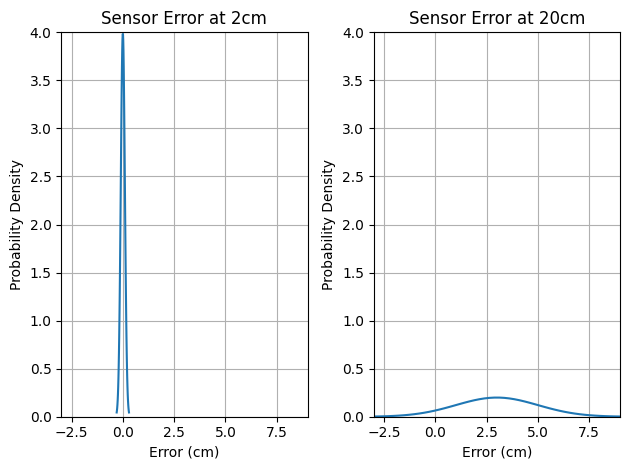

In [29]:
# Consider a time of flight distance sensor that you are "testing" with two distances; 2cm and 20cm. 
# The standard deviation of the noise at 2cm is 1mm, and at 20cm it is 2cm. At a distance of 20cm the sensor is also
#.  biased by 3.0cm - i.e., on average, if something is 20cm away it will say it is 23.0cm away

# Scipy stats has a function that takes in a mean and a standard deviation and returns a function that is that Gaussian distribution
from scipy.stats import norm


#  GUIDE Create plots (using np.random.normal()) that show what the expected error for the sensor at 2cm and 20cm
#.    Don't forget labels
# Note: Does it make sense to plot for distances < 0? 
fig, axs = plt.subplots(1, 2)

# mu and sd
mu_2cm = 0
sd_2cm = .1
mu_20cm = 3
sd_20cm = 2

# plot +/- 3 standard deviations from the mean
range_2cm = np.linspace(mu_2cm - (3*sd_2cm), mu_2cm + (3*sd_2cm))
range_20cm = np.linspace(mu_20cm - (3*sd_20cm), mu_20cm + (3*sd_20cm))

# generate random var
rv_2cm = norm(loc=mu_2cm, scale=sd_2cm)
rv_20cm = norm(loc=mu_20cm, scale=sd_20cm)

# plot
axs[0].plot(range_2cm, rv_2cm.pdf(range_2cm))
axs[1].plot(range_20cm, rv_20cm.pdf(range_20cm))
# labels
axs[0].set_title("Sensor Error at 2cm")
axs[1].set_title("Sensor Error at 20cm")
axs[0].set_xlabel("Error (cm)")
axs[0].set_ylabel("Probability Density")
axs[0].grid(True)
axs[1].set_xlabel("Error (cm)")
axs[1].set_ylabel("Probability Density")
axs[1].grid(True)
# set consistent scale
x_min = min(mu_2cm - 3*sd_2cm, mu_20cm - 3*sd_20cm)
x_max = max(mu_2cm + 3*sd_2cm, mu_20cm + 3*sd_20cm)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(0, 4)
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(0, 4)

fig.tight_layout()

# Example of plotting a normal function - edit this
# How to create 
# rv = norm(loc=0.0, scale=1.0)
# ts = np.linspace(-1.0, 1.0)
# axs[0].plot(ts, rv.pdf(ts))
# fig.tight_layout()

In [30]:
grader.check("Gaussian")

Gaussian results: All test cases passed!

# Probability mass function (discrete) 

Also known as: Importance sampling. 

This is a more general version of the previous bin variable, with the main difference being that each bin has a different liklihood. So it's a combination of the discrete variable (using a running sum to determine which bin you fall in) and the bins (chopping up a continuous variable into bins). 

For this assignment we'll set the probabilities (liklihood) of each bin from a function.

Technical note: In theory land, there is a difference between doing this as a continuous function (probability density) versus chopping it up into pieces (probability mass). You can actually do continuous functions, but it's a bit trickier and we don't need it (see for example https://www.comsol.com/blogs/sampling-random-numbers-from-probability-distribution-functions/)

For this example we're going to use a class instead of a method because (in order to make it efficient) you want to pre-calculate a running sum from the given probabilities. It would be very expensive to do this every time you asked for a sample, like you did in the discrete problem.

This is also a good time to do some fancy numpy array stuff, namely, using "where" to find the index (instead of writing your own for loop)

In [31]:
# pmf: probability that a discrete random variable is exactly equal to a value
class SampleProbabilityMassFunction:
    def __init__(self, in_pdf, x_range=(0.0, 1.0), n_bins=100):
        """ Given a probability mass function, what range of x to use, and the number of samples, create the running
        sum/data needed to generate random samples from that pmf
        @param in_pdf - the function representing the probability distribution
        @param x_range - min and max x values as a tuple
        @param n_bins - number of bins """

        # To "keep" a variable, use self.variable_name
        self.start = x_range[0]
        self.end = x_range[1]
        self.n_bins = n_bins
        self.in_pdf = in_pdf

        self.bin_centers = np.zeros(shape=(n_bins))
        self.bin_heights = np.zeros(shape=(n_bins))
        self.bin_sum = np.zeros(shape=n_bins+1) # [0] = 0, [-1] = 1

        # GUIDE - Initialize correctly
        #  Where the bins start and end
        #.     Where the center of each bin is
        for i in range(n_bins):
            self.bin_centers[i] = self.get_bin_center(i)

        #  The amount of probability to put in each bin
        #.     Sample the in_pdf function at the center of the bin
        #.     Normalize the probabilities so they sum to 1
        self.bin_heights = in_pdf(self.bin_centers)
        self.bin_heights /= np.sum(self.bin_heights)

        #  The running sum
        #.     Calculate the left (and right) boundaries on the unit interval for each bin
        # Running sum of probabilities - bin_sum[i] = sum(bin_heights[0:i])
        #  Note: It's a bit easier to generate_sample if you make this array n_bins+1, with the first value being 0
        #   and the last value being 1   
        self.bin_sum[1:] = np.cumsum(self.bin_heights)
        
        # Create the pmf by evaluating in_pdf at the center of each bin
        #   Don't forget to normalize - the sum of self.bin_heights should be 1
      

    def get_bin_center(self, indx : int):
        """ Return the center of bin indx (i.e., in our 2 bin on the unit interval example, 
        0 would return 0.25 and 1 would return 0.75) 
        @param indx : which bin
        @return bin center"""
        # GUIDE Return the bin center
        bin_size = (self.end - self.start) / self.n_bins
        return self.start + (bin_size / 2) + (bin_size * indx)

    def get_bin_probability(self, indx : int):
        """ Return the probability of that bin being selected
        @param indx : which bin
        @return probability"""
        # GUIDE return the probability
        return self.bin_heights[indx]
    
    def generate_sample(self):
        """ Draw one sample from the pmf
        Very similar to the discrete example above, for picking which bin, except you've pre-calculated the running sum.
        Very similar to bin_sample for returning the bin center, exept you've pre-calculated the bin centers
        @return bin center """
        zero_to_one = np.random.uniform()

        # You want the index i where bin_sum[i] <= zero_to_one < bin_sum[i+1]
        # Not fancy version: Use a for loop
        # Fancy version: Use np.where - see tutorial on where
        # GUIDE - return correct bin center               
        idx = np.where(self.bin_sum <= zero_to_one)[0][-1] # the last element of the arr of all sums that are less than zero to one
        idx = min(idx, self.n_bins - 1) # edge case
        return self.bin_centers[idx]

    def _generate_counts(self, n_samples : 100):
        """ Generate n samples
        @param n_samples - number of samples per bin
        @returns a numpy array with the counts for each bin, normalized"""

        # Counts
        counts = np.zeros(self.n_bins)

        # Call generate_sample many times
        for _ in range(0, self.n_bins * n_samples):
            x_value = self.generate_sample()
            # Should be between 0 and n_bins - 1
            assert x_value > self.start and x_value < self.end
            # Convert x value to 0, 1
            x_value_zero_one = convert_start_stop_to_zero_one(x_value, self.start, self.end)
            # convert 0, 1 value to n_bins
            x_value_bin_indx = x_value_zero_one * self.n_bins
            bin_index = np.floor(x_value_bin_indx)
            counts[int(bin_index)] += 1.0

        # Normalize
        counts = counts / sum(counts)
        return counts

    def test_self(self, in_pdf, b_print=True):
        """ Check/test function
        @param in_pdf - the pdf function used to generate the values
        @returns True/False"""

        # Expected probability values
        bin_centers = np.zeros((self.n_bins))
        for indx in range(0, self.n_bins):
            bin_centers[indx]= self.get_bin_center(indx)

        # Evaluate the function in_pdf at the bin centers 
        expected_probs = in_pdf(self.bin_centers)
        
        # Normalize
        expected_probs /= np.sum(expected_probs)

        # Call the generate_sample method many, many times
        counts = self._generate_counts(n_samples=100)

        # This cute trick loops over expected probabilities and counts at the same time
        #.   requires that the two be arrays of the same size
        for exp, c in zip(expected_probs, counts):
            if b_print:
                print(f"pmf perc {c} expected {exp}")

            if np.abs(exp - c) > 0.1:
                print("Failed")
                return False

        if b_print:
            print("Passed")
        return True


In [32]:
def pdf(x):
    """ Made-up pdf (a quadratic). Can be anything, as long as it's not negative
    @param x
    @ return (x+1) * (x+1) + 0.1"""
    return (x+1) ** 2 + 0.1


In [33]:
# Syntax check
x_min = -2.0
x_max = 1.0
n_bins = 10

# Make the class. Reminder, if you change the class, you need to re-execute the class definition cell
my_sample = SampleProbabilityMassFunction(pdf, (x_min, x_max), n_bins)
# Generate a sample
ret_value = my_sample.generate_sample()
if x_min < ret_value < x_max:
    print("PMF: Passed syntax check")

PMF: Passed syntax check


In [34]:
# GUIDE: Write some more test code to see if your class is doing the right thing...

In [35]:
# Now check that it actually returns the correct counts
my_pmf = SampleProbabilityMassFunction(in_pdf=pdf, x_range=(-2.0, 1.0), n_bins=10)

# Call the test function on the class
assert my_pmf.test_self(in_pdf=pdf)

pmf perc 0.069 expected 0.07528604118993137
pmf perc 0.038 expected 0.03684210526315791
pmf perc 0.016 expected 0.01487414187643021
pmf perc 0.014 expected 0.009382151029748285
pmf perc 0.022 expected 0.020366132723112128
pmf perc 0.052 expected 0.04782608695652174
pmf perc 0.098 expected 0.0917620137299771
pmf perc 0.152 expected 0.1521739130434783
pmf perc 0.229 expected 0.2290617848970252
pmf perc 0.31 expected 0.3224256292906178
Passed


Should both be 1.0: 1.0, 1.0


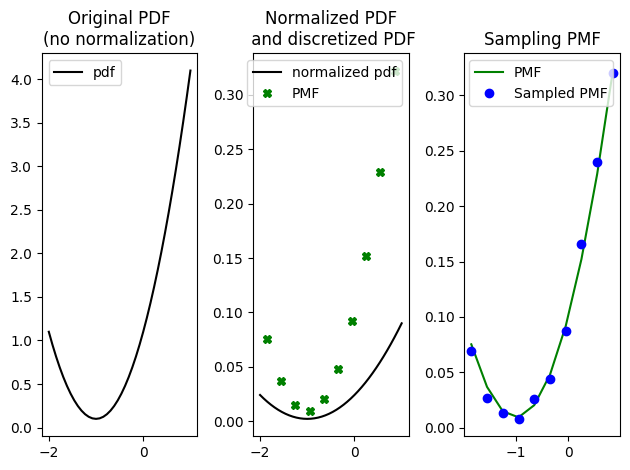

In [36]:
# This is just to help you visualize what is going on/what you're trying to do
fig_2, axs_2 = plt.subplots(1, 3)

# First, plot the original, continuous pdf NORMALIZED
ts_pdf = np.linspace(my_sample.start, my_sample.end, 4 * my_sample.n_bins)
ys_pdf = pdf(ts_pdf)
axs_2[0].plot(ts_pdf, ys_pdf, '-k', label="pdf")
axs_2[0].set_title("Original PDF\n(no normalization)")
axs_2[0].legend()

# Now do the normalized plot and your pmf
ys_pdf_normalized = ys_pdf / np.sum(ys_pdf)
axs_2[1].plot(ts_pdf, ys_pdf_normalized , '-k', label="normalized pdf")

check_bin_centers = np.zeros((my_sample.n_bins))
check_bin_values = np.zeros((my_sample.n_bins))
for indx in range(0, my_sample.n_bins):
    check_bin_centers[indx] = my_sample.get_bin_center(indx)
    check_bin_values[indx] = my_sample.get_bin_probability(indx)
axs_2[1].plot(check_bin_centers, check_bin_values, 'gX', label="PMF")
axs_2[1].set_title("Normalized PDF\n and discretized PDF")
axs_2[1].legend()

# Reconstructed counts
counts = my_sample._generate_counts(n_samples=100)
axs_2[2].set_title("Sampling PMF")

axs_2[2].plot(check_bin_centers, check_bin_values , '-g', label="PMF")
axs_2[2].plot(check_bin_centers, counts, 'ob', label="Sampled PMF")
axs_2[2].legend()

print(f"Should both be 1.0: {np.sum(ys_pdf_normalized)}, {np.sum(check_bin_values)}")
fig_2.tight_layout()

In [37]:
grader.check("pmf")

pmf results: All test cases passed!

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [38]:

# GUIDE - set to correct value               
# List of names (creates a set)
worked_with_names = {"none"}
# List of URLS W26 (creates a set)
websites = {"https://www.geeksforgeeks.org/numpy/numpy-where-in-python/"}
# Approximate number of hours, including lab/in-class time
hours = 2.5


In [39]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Take out/suppress all print statements you put in (can leave the ones given you)
- Do a restart then run all to make sure everything runs ok
- Make sure plots are visible
- Save the file
- Submit this .ipynb file through gradescope, Homework 1

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

